In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install SimpleITK

In [0]:
import os
import numpy as np
from nibabel.testing import data_path
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from scipy import ndimage

In [0]:
def show_image(input_image): 
  rotated_img = ndimage.rotate(input_image, 90)
  plt.imshow(rotated_img, cmap='gray')

#Loading the Training Images


In [0]:
slice_no = 150

# Get nibabel image object
training_labels_load = nib.load("/content/drive/My Drive/Colab Notebooks/MISA_Lab3/bspline_out/out_images1/result.nii")
training_labels=training_labels_load.get_fdata()

training_image_load = nib.load("/content/drive/My Drive/Colab Notebooks/MISA_Lab3/bspline_out/out_images1/result.0.nii")
training_image=training_image_load.get_fdata()

training_labels_vector =  np.reshape(training_labels, training_labels.shape[0]*training_labels.shape[1]*training_labels.shape[2], order='F')
training_image_vector =  np.reshape(training_image, training_image.shape[0]*training_image.shape[1]*training_image.shape[2], order='F')

for i in range (2,15):
  training_labels_load = nib.load("/content/drive/My Drive/Colab Notebooks/MISA_Lab3/bspline_out/out_images"+str(i)+"/result.nii")
  training_labels=training_labels_load.get_fdata()
  training_image_load = nib.load("/content/drive/My Drive/Colab Notebooks/MISA_Lab3/bspline_out/out_images"+str(i)+"/result.0.nii")
  training_image=training_image_load.get_fdata()

  training_labels_vector = np.vstack((training_labels_vector, np.reshape(training_labels, training_labels.shape[0]*training_labels.shape[1]*training_labels.shape[2], order='F')))
  training_image_vector = np.vstack((training_image_vector, np.reshape(training_image, training_image.shape[0]*training_image.shape[1]*training_image.shape[2], order='F')))

#Tissue Models

##Generating the Tissue Model

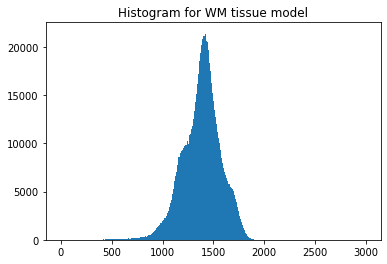

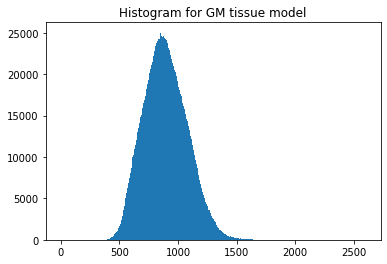

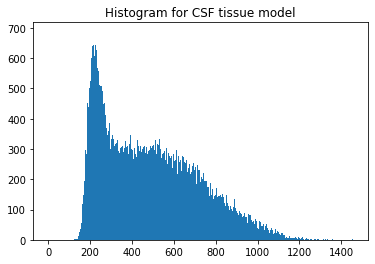

In [6]:
import numpy.ma as ma

GM_tissue_model_vector = []
WM_tissue_model_vector = []
CSF_tissue_model_vector = []
for i in range (1,14):
  im_mask_GM = (training_labels_vector[i,:] == 3);
  GM_compressed = ma.array(training_image_vector[i,:], mask=~im_mask_GM).compressed()
  GM_tissue_model_vector = np.concatenate((GM_tissue_model_vector, GM_compressed))

  im_mask_WM = (training_labels_vector[i,:] == 2);
  WM_compressed = ma.array(training_image_vector[i,:], mask=~im_mask_WM).compressed()
  WM_tissue_model_vector = np.concatenate((WM_tissue_model_vector, WM_compressed))   

  im_mask_CSF = (training_labels_vector[i,:] == 1);
  CSF_compressed = ma.array(training_image_vector[i,:], mask=~im_mask_CSF).compressed()
  CSF_tissue_model_vector = np.concatenate((CSF_tissue_model_vector, CSF_compressed)) 

def tissue_model_histogram(tissue_model_array, tissue_str):
  tissue_histogram_val = np.histogram(tissue_model_array.astype(int), bins=np.arange(np.max(tissue_model_array.astype(int))+1),range= (tissue_model_array.min,tissue_model_array.max))
  _ = plt.hist(tissue_model_array.astype(int), bins=np.arange(np.max(tissue_model_array.astype(int))+1))  # arguments are passed to np.histogram
  plt.title("Histogram for "+ tissue_str +" tissue model")
  plt.show()
  return tissue_histogram_val

WM_histogram = tissue_model_histogram(WM_tissue_model_vector,"WM")
GM_histogram = tissue_model_histogram(GM_tissue_model_vector,"GM")
CSF_histogram = tissue_model_histogram(CSF_tissue_model_vector,"CSF")


##Tissue Model Normaliztion

In [11]:
tissue_model_array_norm = np.zeros((3,np.amax([WM_histogram[0].shape[0], GM_histogram[0].shape[0], CSF_histogram[0].shape[0]])),dtype=int)

tissue_model_array_norm[0,0:WM_histogram[0].shape[0]]= WM_histogram[0]
tissue_model_array_norm[1,0:GM_histogram[0].shape[0]]= GM_histogram[0]
tissue_model_array_norm[2,0:CSF_histogram[0].shape[0]]= CSF_histogram[0]

WM_histogram_norm = np.nan_to_num(tissue_model_array_norm[0,:]/(tissue_model_array_norm[0,:]+tissue_model_array_norm[1,:]+tissue_model_array_norm[2,:]))
GM_histogram_norm = np.nan_to_num(tissue_model_array_norm[1,:]/(tissue_model_array_norm[0,:]+tissue_model_array_norm[1,:]+tissue_model_array_norm[2,:]))
CSF_histogram_norm = np.nan_to_num(tissue_model_array_norm[2,:]/(tissue_model_array_norm[0,:]+tissue_model_array_norm[1,:]+tissue_model_array_norm[2,:]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


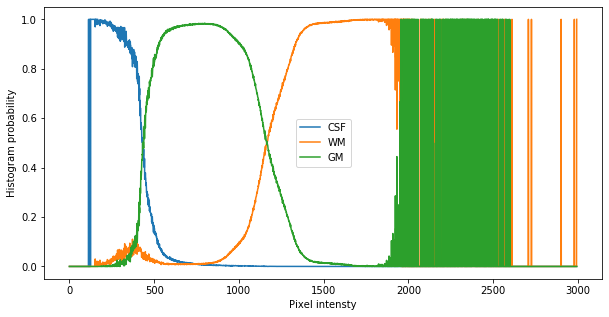

In [12]:
plt.figure(figsize=(10,5))
#plt.subplot(1,3,1)
plt.plot(np.arange(np.max(CSF_histogram_norm.shape[0])),CSF_histogram_norm, label = "CSF")
#plt.subplot(1,3,2)
plt.plot(np.arange(np.max(WM_histogram_norm.shape[0])),WM_histogram_norm, label = "WM")
#plt.subplot(1,3,3)
plt.plot(np.arange(np.max(GM_histogram_norm.shape[0])),GM_histogram_norm, label = "GM")


# naming the x axis 
plt.xlabel('Pixel intensty') 
# naming the y axis 
plt.ylabel('Histogram probability') 

# show a legend on the plot 
plt.legend() 
  
# function to show the plot 
plt.show() 


##Saving the Tissue Models

In [0]:
np.save("/content/drive/My Drive/Colab Notebooks/MISA_Lab3/tissue_model/WM_histogram_norm.npy",WM_histogram_norm)
np.save("/content/drive/My Drive/Colab Notebooks/MISA_Lab3/tissue_model/GM_histogram_norm.npy",GM_histogram_norm)
np.save("/content/drive/My Drive/Colab Notebooks/MISA_Lab3/tissue_model/CSF_histogram_norm.npy",CSF_histogram_norm)

#Atlases

##Generating Atlases

In [0]:
CSF_array = np.multiply((training_labels_vector==1), 1) 
CSF_vect = np.mean(CSF_array, axis=0)
CSF_prob_map = np.reshape(CSF_vect, (256, 287, 256), order='F')

WM_array = np.multiply((training_labels_vector==2), 1) 
WM_vect = np.mean(WM_array, axis=0)
WM_prob_map = np.reshape(WM_vect, (256, 287, 256), order='F')

GM_array = np.multiply((training_labels_vector==3), 1) 
GM_vect = np.mean(GM_array, axis=0)
GM_prob_map = np.reshape(GM_vect, (256, 287, 256), order='F')

tissue_model_vect = np.mean(training_image_vector, axis=0)
tissue_model = np.reshape(tissue_model_vect, (256, 287, 256), order='F')

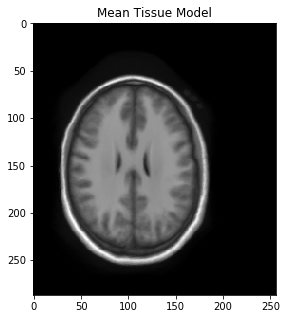

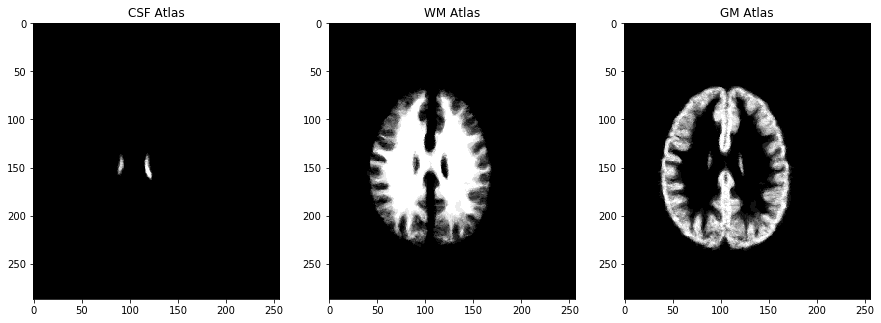

In [10]:
plt.figure(figsize=(5,5))
plt.title("Mean Tissue Model")
show_image(tissue_model[:,:,slice_no])

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.title("CSF Atlas")
show_image(CSF_prob_map[:,:,slice_no])
plt.subplot(1,3,2)
plt.title("WM Atlas")
show_image(WM_prob_map[:,:,slice_no])
plt.subplot(1,3,3)
plt.title("GM Atlas")
show_image(GM_prob_map[:,:,slice_no])


##Saving Atlases

In [0]:
save_img = nib.Nifti1Image(GM_prob_map, training_image_load.affine, training_image_load.header)
nib.save(save_img, 'GM_prob_map.nii.gz')
save_img = nib.Nifti1Image(WM_prob_map, training_image_load.affine, training_image_load.header)
nib.save(save_img, 'WM_prob_map.nii.gz')
save_img = nib.Nifti1Image(CSF_prob_map, training_image_load.affine, training_image_load.header)
nib.save(save_img, 'CSF_prob_map.nii.gz')
save_img = nib.Nifti1Image(tissue_model, training_image_load.affine, training_image_load.header)
nib.save(save_img, 'tissue_model.nii.gz')

save_img = nib.Nifti1Image(GM_prob_map, training_image_load.affine, training_image_load.header)
nib.save(save_img, 'GM_prob_map.nii')
save_img = nib.Nifti1Image(WM_prob_map, training_image_load.affine, training_image_load.header)
nib.save(save_img, 'WM_prob_map.nii')
save_img = nib.Nifti1Image(CSF_prob_map, training_image_load.affine, training_image_load.header)
nib.save(save_img, 'CSF_prob_map.nii')
save_img = nib.Nifti1Image(tissue_model, training_image_load.affine, training_image_load.header)
nib.save(save_img, 'tissue_model.nii')